# Example for creating family of DRO via Natural Parameter Continuation

Yuri Shimane

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import plotly.express as px
import pandas as pd
from tqdm.notebook import tqdm

%matplotlib inline

In [2]:
import sys
sys.path.append('../')   # path to polaris module

import polaris.SolarSystemConstants as sscs
import polaris.Keplerian as kepl
import polaris.Propagator as prop
import polaris.R3BP as r3bp

In [3]:
param_earth_moon = r3bp.get_cr3bp_param('399','301')   # NAIF ID's '399': Earth, '301': Moon
lp = r3bp.lagrangePoints(param_earth_moon.mu)
param_earth_moon.mu

0.012150584269940354

In [5]:
# initial member
# state0  = np.array([1.16935708791412, 0.0, 0.096785570098781, 0.0, -0.19393150190919, 0.0])
# period0 = 3.33357641283143

period0 = 0.8045764128313149
state0 = np.array([1.0510483249552647, 0.0, 0.0, 0.0, -0.5071069106969985, 0.0])

# initialize list and append initial member
proplst = []
proplst.append( prop.propagate_cr3bp(param_earth_moon, state0, period0) )

# setup array of periods to use
step_period = 0.005
stop_period = 6.4
periods = np.arange(period0, stop_period, step_period)

len(periods), stop_period

(1120, 6.4)

In [7]:
# initialize pandas dataframe
df_keys = ["System", "Family", "mu", "Period", "Jacobi", "Stability", 
           "state_x", "state_y", "state_z", "state_vx", "state_vy", "state_vz",]
famdf = pd.DataFrame( columns=df_keys )
solcount = 0   # number of solutions

# run single shooting
state_iter = state0
p_iter     = period0
for period in tqdm(periods):
    p_iter, state_iter, conv_iter = r3bp.ssdc_periodic_xzplane(param_earth_moon, state_iter, period, 
                                                               fix="period", message=False)
    if conv_iter==1:
        # store propagation output for plotting
        proptmp = prop.propagate_cr3bp(param_earth_moon, state_iter, p_iter, stm_option=True)
        proplst.append( proptmp )
        monodromy = np.reshape( proptmp.stms[:,-1] , (6,6) )
        # store solution into dataframe
        snew = pd.Series(["Earth_Moon",
                          "dro",
                          param_earth_moon.mu,
                          p_iter,
                          r3bp.jacobiConstant(param_earth_moon.mu, state_iter),
                          r3bp.stabilityIndex(monodromy), 
                          state_iter[0], state_iter[1], state_iter[2], 
                          state_iter[3], state_iter[4], state_iter[5] ], index=df_keys, name=int(solcount))
        famdf = pd.DataFrame.append(famdf, snew)
        solcount += 1
    else:
        print(f'Breaking at {period}!')
        break

  0%|          | 0/1120 [00:00<?, ?it/s]

Breaking at 6.30457641283132!


  0%|          | 0/1102 [00:00<?, ?it/s]

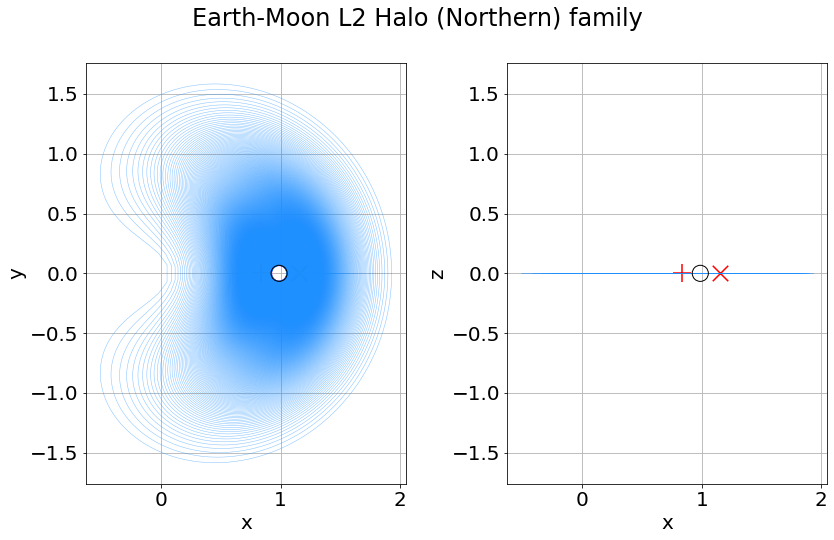

In [8]:
# plot resulting family
plt.rcParams["font.size"] = 20
fig, axs = plt.subplots(1, 2, figsize=(12,8))

axs[0].plot(proplst[0].xs, proplst[0].ys, linewidth=1, c='m', alpha=1)
axs[1].plot(proplst[0].xs, proplst[0].zs, linewidth=1, c='m', alpha=1)

for propout in tqdm(proplst):
    axs[0].plot(propout.xs, propout.ys, linewidth=0.5, c='dodgerblue', alpha=0.55)
    axs[1].plot(propout.xs, propout.zs, linewidth=0.5, c='dodgerblue', alpha=0.55)
    
for idx in range(2):
    axs[idx].grid(True)
    axs[idx].axis("equal")
    axs[idx].scatter(1-param_earth_moon.mu, 0., marker='o', facecolor="none", edgecolor='k', zorder=3, s=260, label='Moon')
    axs[idx].scatter(lp.l1[0], lp.l1[1], marker='+', c='r', s=340)
    axs[idx].scatter(lp.l2[0], lp.l2[1], marker='x', c='r', s=240)

axs[0].set(xlabel="x", ylabel="y")
axs[1].set(xlabel="x", ylabel="z")

plt.suptitle('Earth-Moon L2 Halo (Northern) family')
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

In [9]:
famdf.iloc[-1,:]["Period"], famdf.iloc[-1,:]["state_x"], famdf.iloc[-1,:]["state_z"], famdf.iloc[-1,:]["state_vy"]

(6.299576412831319, 1.9291306902321075, 0.0, -1.7281543608810406)

In [10]:
famdf.iloc[1,:]

System       Earth_Moon
Family              dro
mu             0.012151
Period         0.809576
Jacobi         3.089335
Stability           1.0
state_x        1.051338
state_y             0.0
state_z             0.0
state_vx            0.0
state_vy      -0.506452
state_vz            0.0
Name: 1, dtype: object

In [11]:
famdf

,System,Family,mu,Period,Jacobi,Stability,state_x,state_y,state_z,state_vx,state_vy,state_vz
0,Earth_Moon,dro,0.012151,0.804576,3.090323,0.000000,1.051048,0.0,0.0,0.0,-0.507107,0.0
1,Earth_Moon,dro,0.012151,0.809576,3.089335,1.000000,1.051338,0.0,0.0,0.0,-0.506452,0.0
2,Earth_Moon,dro,0.012151,0.814576,3.088357,0.000000,1.051627,0.0,0.0,0.0,-0.505806,0.0
3,Earth_Moon,dro,0.012151,0.819576,3.087387,0.000000,1.051916,0.0,0.0,0.0,-0.505167,0.0
4,Earth_Moon,dro,0.012151,0.824576,3.086427,0.000000,1.052205,0.0,0.0,0.0,-0.504535,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...
1095,Earth_Moon,dro,0.012151,6.279576,2.128780,1.000000,1.828828,0.0,0.0,0.0,-1.522467,0.0
1096,Earth_Moon,dro,0.012151,6.284576,2.071341,1.000219,1.848790,0.0,0.0,0.0,-1.560953,0.0
1097,Earth_Moon,dro,0.012151,6.289576,2.000015,1.000194,1.871501,0.0,0.0,0.0,-1.605886,0.0
1098,Earth_Moon,dro,0.012151,6.294576,1.907414,1.000159,1.897840,0.0,0.0,0.0,-1.659967,0.0


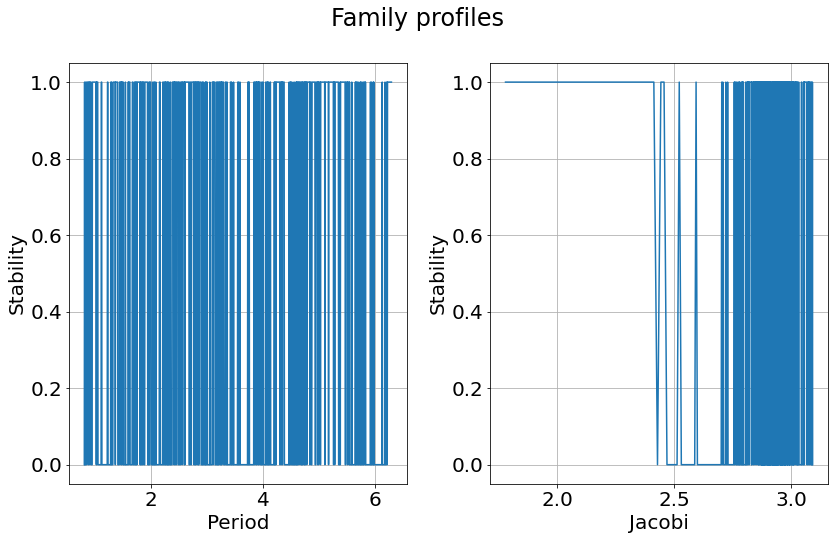

In [12]:
plt.rcParams["font.size"] = 20
fig, axs = plt.subplots(1, 2, figsize=(12,8))
axs[0].plot(famdf["Period"], famdf["Stability"])
axs[0].set(xlabel="Period", ylabel="Stability")
axs[0].grid(True)

axs[1].plot(famdf["Jacobi"], famdf["Stability"])
axs[1].set(xlabel="Jacobi", ylabel="Stability")
axs[1].grid(True)

plt.suptitle('Family profiles')
plt.tight_layout(rect=[0, 0.03, 1, 1])
plt.show()

### Save resulting family into JSON file

In [ ]:
raise SystemExit("Stop before saving!")

In [84]:
# save output
flename = "distantRetrogradeOrbit_test.json"
pathjson = '../data/r3bp/EarthMoon/' + flename
famdf.to_json(pathjson, orient='index', indent=4, double_precision=15)

print(f'Done! Saved at {pathjson}')

Done! Saved at ../data/r3bp/EarthMoon/distantRetrogradeOrbit_test.json
